In [1]:
from typing import Dict
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool
from langchain_community.utilities import SQLDatabase
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
user = "root"
password = "vonuhuyentran1202"
host = "localhost"
port = "3306"
db_name = "research"

db = SQLDatabase.from_uri(
    f"mysql+pymysql://{user}:{password}@{host}:{port}/{db_name}"
)

In [3]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.0,
    max_tokens=100,
)

In [6]:
from typing_extensions import TypedDict, Annotated

class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."] 

In [15]:
system_message = """
Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}
"""

user_prompt = "Question: {input}"

query_prompt_template = ChatPromptTemplate(
    [("system", system_message), ("user", user_prompt)]
)


def write_query(state: State) -> Dict[str, str]:
    """
        Generate SQL query to fetch information.
    """

    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )

    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)

    return {"query": result["query"]}


def execute_query(state: State):
    """
        Execute SQL query.
    """

    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}


def generate_answer(state: State):
    """
        Answer question using retrieved information as context.
    """
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    
    return {"answer": response.content}

In [16]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
for step in graph.stream(
    {"question": "How many articles are there?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT count(*) FROM articles'}}
{'execute_query': {'result': '[(24,)]'}}
{'generate_answer': {'answer': 'There are 24 articles.'}}


In [21]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["execute_query"])

# Now that we're using persistence, we need to specify a thread ID
# so that we can continue the run after review.
config = {"configurable": {"thread_id": "1"}}

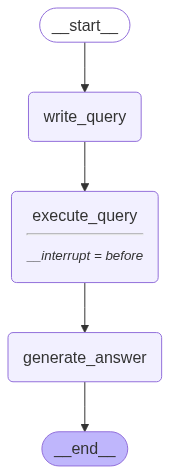

In [22]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001F6984CBD70>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001F6984CBD70>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001F6984CBD70>),
 QuerySQLCheckerTool(description='Use this tool to 

In [19]:
import ast
import re


def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if el]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))


authors = query_as_list(db, "SELECT Author FROM Articles")
fullnames = query_as_list(db, "SELECT FullName FROM Users")
fullnames[:5]

['Nguyễn Văn A', 'Pham Nhat Khoa', 'sdfdf', 'Trần Thị B', 'fdff']

In [20]:
res = db.run("SELECT FullName FROM Users")
res = [el for sub in ast.literal_eval(res) for el in sub if el]
res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
res

['Nguyễn Văn A', 'Trần Thị B', 'sdfdf', 'sdfdf', 'fdff', 'Pham Nhat Khoa']

In [21]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# Khởi tạo embedding model
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

vector_store = InMemoryVectorStore(embeddings)

from langchain.agents.agent_toolkits import create_retriever_tool

_ = vector_store.add_texts(authors + fullnames)
retriever = vector_store.as_retriever(search_kwargs={"k": 5})
description = (
    "Use to look up values to filter on. Input is an approximate spelling "
    "of the proper noun, output is valid proper nouns. Use the noun most "
    "similar to the search."
)
retriever_tool = create_retriever_tool(
    retriever,
    name="search_proper_nouns",
    description=description,
)

In [13]:
vector_store

In [17]:
text = "LangChain makes working with LLMs easier"
embedding_vector = embeddings.embed_query(text)
len(embedding_vector)

768

In [22]:
print(retriever_tool.invoke("A"))

Trần Thị B

Trần Thị B

Nguyễn Văn A

Nguyễn Văn A

fdfff


In [ ]:
from langgraph.prebuilt import create_react_agent
from langchain_community.agent_toolkits import SQLDatabaseToolkit


toolkit = SQLDatabaseToolkit(
        db=db, 
        llm=llm
)

tools = toolkit.get_tools()

system_message = """
    You are an agent designed to interact with a SQL database.
    Given an input question, create a syntactically correct {dialect} query to run,
    then look at the results of the query and return the answer. Unless the user
    specifies a specific number of examples they wish to obtain, always limit your
    query to at most {top_k} results.

    You can order the results by a relevant column to return the most interesting
    examples in the database. Never query for all the columns from a specific table,
    only ask for the relevant columns given the question.

    You MUST double check your query before executing it. If you get an error while
    executing a query, rewrite the query and try again.

    DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
    database.

    To start you should ALWAYS look at the tables in the database to see what you
    can query. Do NOT skip this step.

    Then you should query the schema of the most relevant tables.
    """.format(
        dialect=db.dialect,
        top_k=5,
    )

# Add to system message
suffix = (
    "If you need to filter on a proper noun like a Name, you must ALWAYS first look up "
    "the filter value using the 'search_proper_nouns' tool! Do not try to "
    "guess at the proper name - use this function to find similar ones."
)

system = f"{system_message}\n\n{suffix}"

tools.append(retriever_tool)

agent = create_react_agent(llm, tools, prompt=system)

In [29]:
question = "How many authors in all articles in table articles and author is in the table Users"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How many authors in all articles in table articles and author is in the table Users
================================== Ai Message ==================================

I need to find out the number of authors from the `Articles` table who are also present in the `Users` table. To do this, I will first list the tables in the database to confirm their existence and then query the schemas of the `Articles` and `Users` tables to understand their structure. Finally, I will construct a SQL query to count the authors present in both tables.
Tool Calls:
  sql_db_list_tables (d342c02e-b36b-497e-b357-35ae8b91bcc2)
 Call ID: d342c02e-b36b-497e-b357-35ae8b91bcc2
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

articles, users
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (8976f124-db33-43ea-b